In [1]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random

In [2]:
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ', dtype=np.float32)

In [3]:
data.shape
np.random.shuffle(data)

In [4]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    np.random.shuffle(data) # 打乱data的顺序
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]


    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [5]:
# 定义网络结构-模型设计
class Regressor(paddle.nn.Layer):
    def __init__(self):
        super(Regressor, self).__init__()

        self.fc = Linear(in_features=13,out_features=1)

    def forward(self,inputs):
        x = self.fc(inputs)
        return x

In [6]:
# 训练配置:设定优化器（参数更新策略）及损失函数
model = Regressor() #创建模型
model.train() # 开启模型的训练模式
# 定义优化算法, 这里使用梯度下降
# model.parameters(), 返回模型的参数
opt = paddle.optimizer.SGD(learning_rate=0.01,parameters=model.parameters())
# 加载数据
train_data,test_data = load_data()

In [7]:
train_data.shape

(404, 14)

In [8]:
# 训练过程
EPOCH_NUM = 10
batch_size = 10

for epoch_id in range(EPOCH_NUM):
    np.random.shuffle(train_data)
    mini_batchs = [train_data[k:k+batch_size] for k in range(0,len(train_data),batch_size)]

    for iter_id,mini_batch in enumerate(mini_batchs):
        x =mini_batch[:,:-1]
        y = mini_batch[:,-1:]

        x = paddle.to_tensor(x)
        y = paddle.to_tensor(y)

        predicts = model(x) # 前向计算，model的训练模型已经开启，直接传值相当于调用forward函数

        loss = F.square_error_cost(predicts,label=y) #计算每一个的损失
        avg_cost = paddle.mean(loss) # 计算平均损失
        if iter_id%20 == 0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_cost.numpy()))

        avg_cost.backward() # 反向传播，相当于求解微分增量的过程
        #根据优化函数，执行参数更新
        opt.step()
        # 清除梯度，即：清除求解的微分增量信息
        opt.clear_grad()

    

epoch: 0, iter: 0, loss is: [0.15334368]
epoch: 0, iter: 20, loss is: [0.11591969]
epoch: 0, iter: 40, loss is: [0.06231583]
epoch: 1, iter: 0, loss is: [0.08054561]
epoch: 1, iter: 20, loss is: [0.15372013]
epoch: 1, iter: 40, loss is: [0.10092942]
epoch: 2, iter: 0, loss is: [0.13305195]
epoch: 2, iter: 20, loss is: [0.05220266]
epoch: 2, iter: 40, loss is: [0.10900329]
epoch: 3, iter: 0, loss is: [0.02062247]
epoch: 3, iter: 20, loss is: [0.02818567]
epoch: 3, iter: 40, loss is: [0.02845579]
epoch: 4, iter: 0, loss is: [0.02581952]
epoch: 4, iter: 20, loss is: [0.02335389]
epoch: 4, iter: 40, loss is: [0.04872174]
epoch: 5, iter: 0, loss is: [0.12444164]
epoch: 5, iter: 20, loss is: [0.0593061]
epoch: 5, iter: 40, loss is: [0.02640297]
epoch: 6, iter: 0, loss is: [0.01478878]
epoch: 6, iter: 20, loss is: [0.10400486]
epoch: 6, iter: 40, loss is: [0.08970744]
epoch: 7, iter: 0, loss is: [0.04988033]
epoch: 7, iter: 20, loss is: [0.06628388]
epoch: 7, iter: 40, loss is: [0.01675369]
e

In [9]:
paddle.save(model.state_dict(),'models/LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


In [11]:
#
def load_one_example():
    idx = np.random.randint(0,test_data.shape[0])
    data,label = test_data[idx,:-1],test_data[idx,-1:]

    return data.reshape(1,-1),label

In [28]:
model_dict = paddle.load('models/LR_model.pdparams')
model.load_dict(model_dict)
# 开启模型的预测模式
model.eval()

# 参数为数据集的文件地址
one_data, label = load_one_example()
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]

label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [[29.309155]], the corresponding label is [15.6]


In [29]:
# ReLU和Sigmoid激活函数示意图
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches


d:\python高级程序设计\.venv\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [30]:
plt.figure(figsize=(8,3))

x = np.arange(-10,10,0.1)
s = 1.0/(1+np.exp(-x))
s

array([4.53978687e-05, 5.01721647e-05, 5.54485247e-05, 6.12797396e-05,
       6.77241496e-05, 7.48462275e-05, 8.27172229e-05, 9.14158739e-05,
       1.01029194e-04, 1.11653341e-04, 1.23394576e-04, 1.36370327e-04,
       1.50710358e-04, 1.66558065e-04, 1.84071905e-04, 2.03426978e-04,
       2.24816770e-04, 2.48455082e-04, 2.74578156e-04, 3.03447030e-04,
       3.35350130e-04, 3.70606141e-04, 4.09567165e-04, 4.52622223e-04,
       5.00201107e-04, 5.52778637e-04, 6.10879359e-04, 6.75082731e-04,
       7.46028834e-04, 8.24424686e-04, 9.11051194e-04, 1.00677082e-03,
       1.11253603e-03, 1.22939862e-03, 1.35851995e-03, 1.50118226e-03,
       1.65880108e-03, 1.83293894e-03, 2.02532039e-03, 2.23784852e-03,
       2.47262316e-03, 2.73196076e-03, 3.01841632e-03, 3.33480731e-03,
       3.68423990e-03, 4.07013772e-03, 4.49627316e-03, 4.96680165e-03,
       5.48629890e-03, 6.05980149e-03, 6.69285092e-03, 7.39154134e-03,
       8.16257115e-03, 9.01329865e-03, 9.95180187e-03, 1.09869426e-02,
      

<Figure size 576x216 with 0 Axes>

In [31]:
y = np.clip(x,a_min=0,a_max=None)

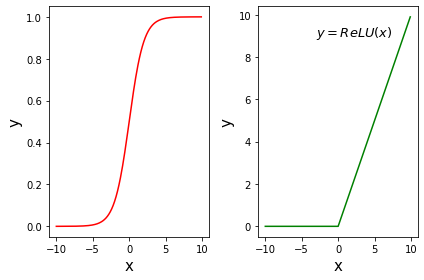

In [35]:
f = plt.subplot(121)
plt.plot(x,s,color='r')
currentAxis = plt.gca()
currentAxis.xaxis.set_label_text('x',fontsize=15)
currentAxis.yaxis.set_label_text('y',fontsize=15)

f = plt.subplot(122)
plt.plot(x,y,color='g')
plt.text(-3.0,9,r'$y=ReLU(x)$',fontsize=13)
currentAxis=plt.gca()
currentAxis.xaxis.set_label_text('x',fontsize=15)
currentAxis.yaxis.set_label_text('y',fontsize=15)
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [11]:
image = Image.open('work/cat.jpg')
image = np.array(image)
image.shape

(400, 400, 3)

In [12]:
type(image)

numpy.ndarray

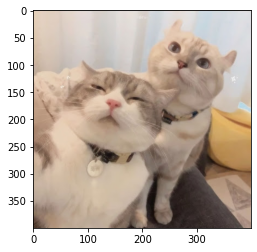

In [14]:
plt.imshow(image)

In [15]:
image2 = image[400:0:-1,:,:] # 起始点，结束点，步长为一

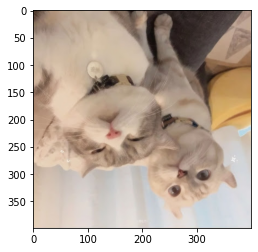

In [16]:
plt.imshow(image2)

In [ ]:
im3 = Image.fromarray(image2)

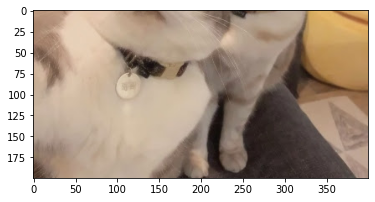

In [17]:
H,W = image.shape[0],image.shape[1]

H1 = H//2
H2 = H

image4 = image[H1:H2,:,:]
plt.imshow(image4)

In [1]:
import paddle
from paddle.nn import Transformer

d_model = 512

# src: [batch_size, tgt_len, d_model]
enc_input = paddle.rand((2, 4, 128))

# tgt: [batch_size, src_len, d_model]
dec_input = paddle.rand((2, 6, 128))
# src_mask: [batch_size, n_head, src_len, src_len]
enc_self_attn_mask = paddle.rand((2, 2, 4, 4))
# tgt_mask: [batch_size, n_head, tgt_len, tgt_len]
dec_self_attn_mask = paddle.rand((2, 2, 6, 6))
# memory_mask: [batch_size, n_head, tgt_len, src_len]
cross_attn_mask = paddle.rand((2, 2, 6, 4))

transformer = Transformer(128, 2, 4, 4, 512)
output = transformer(enc_input,
                     dec_input,
                     enc_self_attn_mask,
                     dec_self_attn_mask,
                     cross_attn_mask)  # [2, 6, 128]

[2, 2, 4, 4]


In [2]:
enc_input.shape

[2, 4, 128]